# Imports

In [9]:
import sys
import os

current_dir = os.getcwd()

parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

print(f"Added to path: {parent_dir}")

Added to path: /home/stavros/emb3/fgsd_method/src


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import warnings
import urllib.request
import zipfile
from sklearn.decomposition import PCA

from sklearn.preprocessing import normalize 

try:
    import umap
    HAS_UMAP = True
except ImportError:
    print("Warning: 'umap-learn' not found. Visualization will only use t-SNE.")
    HAS_UMAP = False

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score


# Setup Paths

In [11]:
current_dir = os.path.dirname(os.path.abspath("__file__"))
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from optimized_method import HybridFGSD 
from fgsd import FlexibleFGSD 

warnings.filterwarnings('ignore')

# Data Loading

In [12]:
def download_and_load_enzymes():
    data_dir = '/tmp/ENZYMES'
    zip_path = os.path.join(data_dir, 'ENZYMES.zip')
    dataset_path = os.path.join(data_dir, 'ENZYMES')
    if not os.path.exists(dataset_path):
        print(f"Dataset not found in {dataset_path}. Downloading...")
        os.makedirs(data_dir, exist_ok=True)
        base_url = 'https://www.chrsmrrs.com/graphkerneldatasets/ENZYMES.zip'
        urllib.request.urlretrieve(base_url, zip_path)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
    graph_indicator = np.loadtxt(os.path.join(dataset_path, 'ENZYMES_graph_indicator.txt'), dtype=int)
    edges = np.loadtxt(os.path.join(dataset_path, 'ENZYMES_A.txt'), dtype=int, delimiter=',')
    graph_labels = np.loadtxt(os.path.join(dataset_path, 'ENZYMES_graph_labels.txt'), dtype=int)
    node_labels_raw = np.loadtxt(os.path.join(dataset_path, 'ENZYMES_node_labels.txt'), dtype=int)
    num_graphs = len(graph_labels)
    graphs = [nx.Graph() for _ in range(num_graphs)]
    node_labels_list = []
    for node_id, graph_id in enumerate(graph_indicator, start=1):
        graphs[graph_id - 1].add_node(node_id)
    current_idx = 0
    for i in range(1, num_graphs + 1):
        count = np.sum(graph_indicator == i)
        labels_of_graph = node_labels_raw[current_idx : current_idx + count]
        node_labels_list.append(labels_of_graph)
        current_idx += count
    for edge in edges:
        node1, node2 = edge
        graph_id = graph_indicator[node1 - 1]
        graphs[graph_id - 1].add_edge(node1, node2)
    graphs = [nx.convert_node_labels_to_integers(g) for g in graphs]
    labels = graph_labels - 1
    return graphs, labels, node_labels_list

# Feature Generation

In [13]:
def create_node_label_features(node_labels_list):
    """
    Creates a histogram of node labels for each graph.
    """
    all_labels = np.concatenate(node_labels_list)
    unique_labels = np.unique(all_labels)
    n_unique = len(unique_labels)
    min_lbl, max_lbl = min(unique_labels), max(unique_labels)
    
    features = []
    for labels in node_labels_list:
        hist, _ = np.histogram(labels, bins=n_unique, range=(min_lbl, max_lbl + 1))
        features.append(hist)
        
    return np.array(features)

def generate_embeddings(graphs, node_labels_list, config):
    """
    Generates Spectral features, generates Node Label features, 
    normalizes them SEPARATELY, and then combines them.
    """
    func = config['func']
    if func == 'hybrid':
        model = HybridFGSD(
            harm_bins=config['harm_bins'], 
            harm_range=config['harm_range'],
            pol_bins=config['pol_bins'], 
            pol_range=config['pol_range'],
            func_type='hybrid', 
            seed=42)
    else:
        model = FlexibleFGSD(
            hist_bins=config['bins'], 
            hist_range=config['range'], 
            func_type=func, 
            seed=42)
            
    model.fit(graphs)
    X_spectral = model.get_embedding()
    
    X_labels = create_node_label_features(node_labels_list)
    
    scaler_spec = StandardScaler()
    X_spectral_norm = scaler_spec.fit_transform(X_spectral)
    
    scaler_lbl = StandardScaler()
    X_labels_norm = scaler_lbl.fit_transform(X_labels)
    
    LABEL_WEIGHT = 100.0 
    X_labels_weighted = X_labels_norm * LABEL_WEIGHT  #
    
    return np.hstack([X_spectral_norm])#, X_labels_weighted])

# Clustering Analysis

In [14]:
def perform_clustering_analysis(X, y_true):
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    X_norm = normalize(X_std, norm='l2')
    pca = PCA(n_components=0.95, random_state=42)
    X_pca = pca.fit_transform(X_norm)
    n_classes = len(np.unique(y_true))
    kmeans = KMeans(n_clusters=n_classes, random_state=42, n_init=50)
    y_kmeans = kmeans.fit_predict(X_pca)
    spectral = SpectralClustering(n_clusters=n_classes, affinity='nearest_neighbors', 
                                  n_neighbors=10, random_state=42, n_jobs=-1)
    y_spectral = spectral.fit_predict(X_pca)
    return X_pca, y_kmeans, y_spectral

# Visualization

In [15]:
def visualize_clusters(X_scaled, y_true, y_kmeans, y_spectral, config_name):
    labels_list = [y_true, y_kmeans, y_spectral]
    if HAS_UMAP:
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        umap_row = axes[0]
        tsne_row = axes[1]
        reducer_umap = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
        embedding_umap = reducer_umap.fit_transform(X_scaled)
        titles_umap = ['GT (UMAP)', 'KMeans (UMAP)', 'Spectral (UMAP)']
        for ax, labels, title in zip(umap_row, labels_list, titles_umap):
            ax.scatter(embedding_umap[:,0], embedding_umap[:,1], c=labels, cmap='tab10', s=15)
            ax.set_title(title); ax.axis('off')
    else:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        tsne_row = axes
    reducer_tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embedding_tsne = reducer_tsne.fit_transform(X_scaled)
    titles_tsne = ['GT (t-SNE)', 'KMeans (t-SNE)', 'Spectral (t-SNE)']
    for ax, labels, title in zip(tsne_row, labels_list, titles_tsne):
        ax.scatter(embedding_tsne[:,0], embedding_tsne[:,1], c=labels, cmap='tab10', s=15)
        ax.set_title(title); ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"clustering_visualization_{config_name}.png")

# Main Execution

Loading Data...

Processing Configuration: hybrid_100_33_100_4.1
--- Metrics for hybrid_100_33_100_4.1 ---
K-Means  -> ARI: 0.0365 | Silhouette: 0.1604
Spectral -> ARI: 0.0264 | Silhouette: 0.1128
Generating Visualization...
Plots displayed above and saved to 'clustering_visualization_hybrid_100_33_100_4.1.png'

Processing Configuration: polynomial_100_4.1
--- Metrics for polynomial_100_4.1 ---
K-Means  -> ARI: 0.0198 | Silhouette: 0.1390
Spectral -> ARI: 0.0216 | Silhouette: 0.1311
Generating Visualization...
Plots displayed above and saved to 'clustering_visualization_polynomial_100_4.1.png'

Processing Configuration: harmonic_300_33
--- Metrics for harmonic_300_33 ---
K-Means  -> ARI: 0.0280 | Silhouette: 0.2183
Spectral -> ARI: 0.0406 | Silhouette: 0.0973
Generating Visualization...
Plots displayed above and saved to 'clustering_visualization_harmonic_300_33.png'


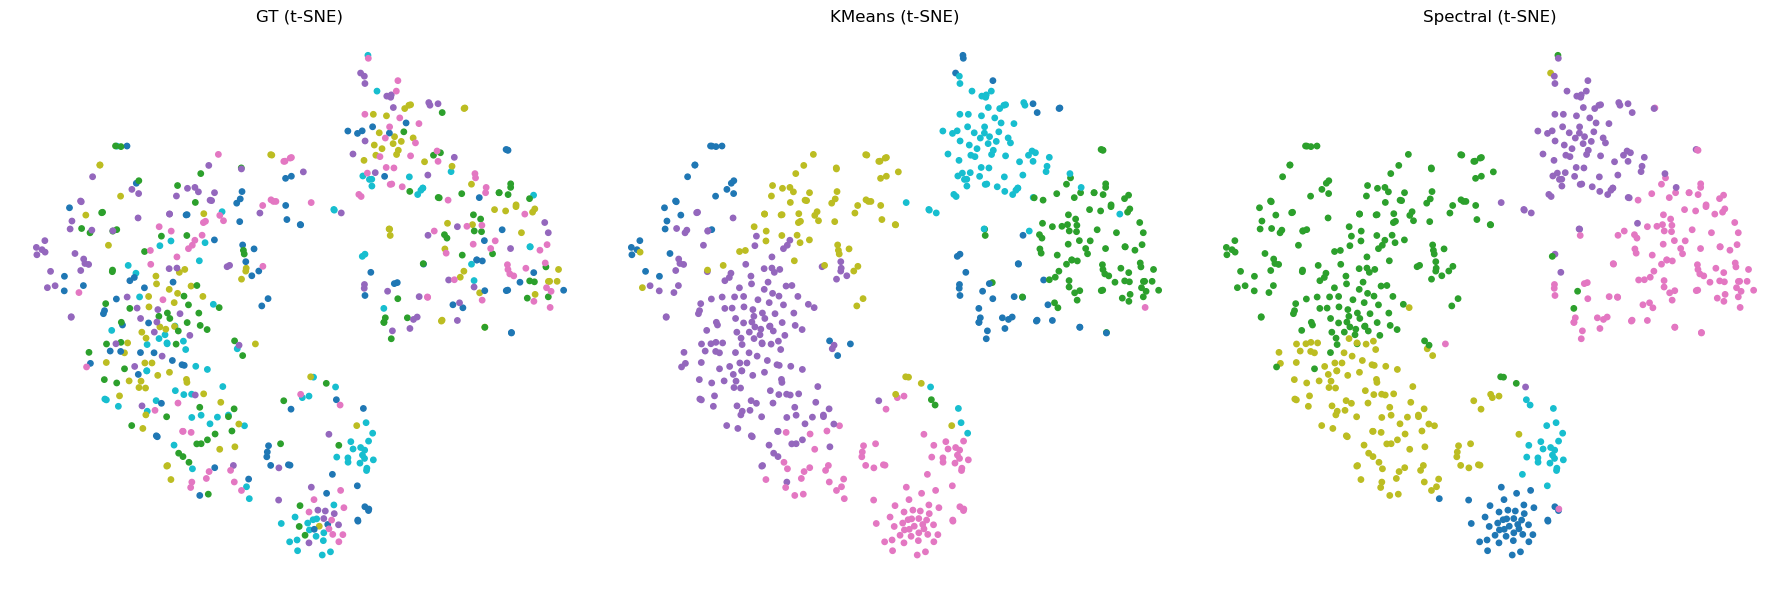

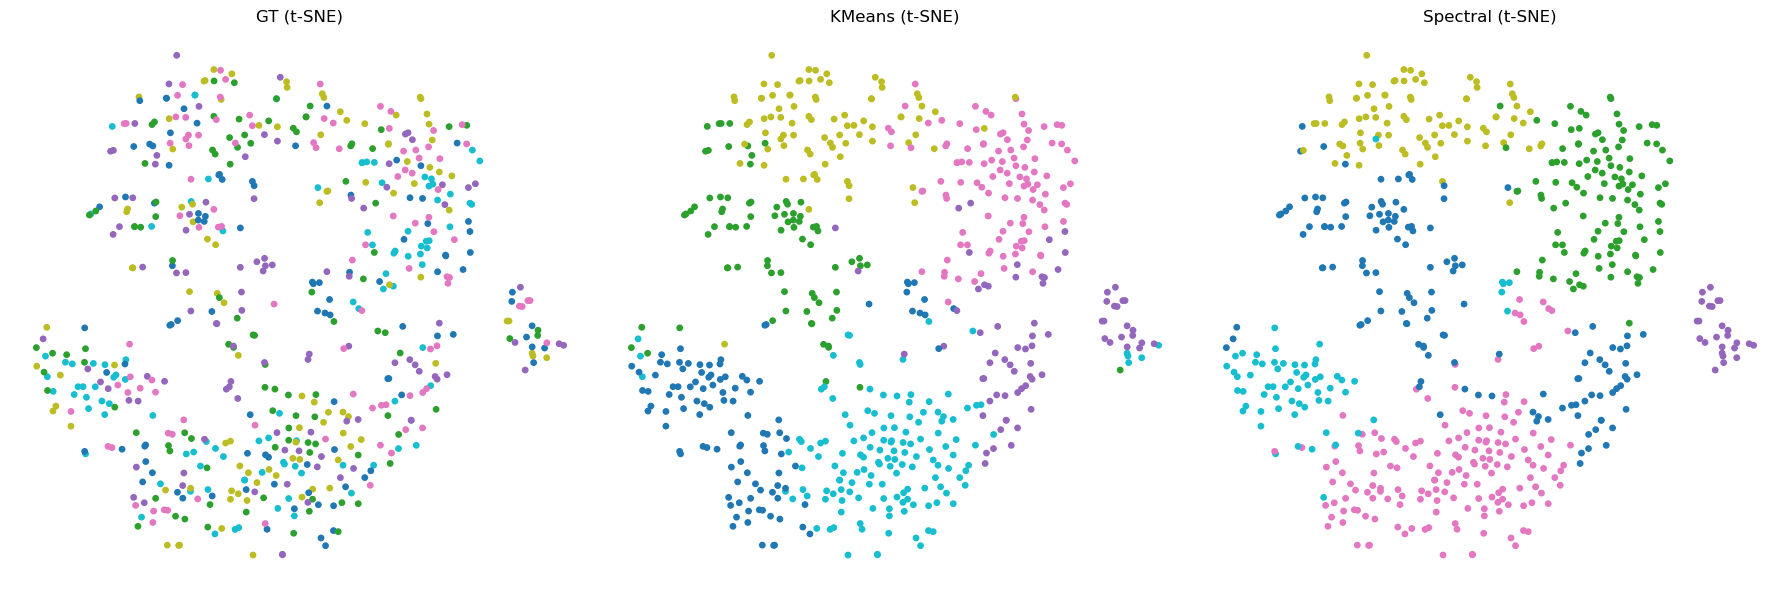

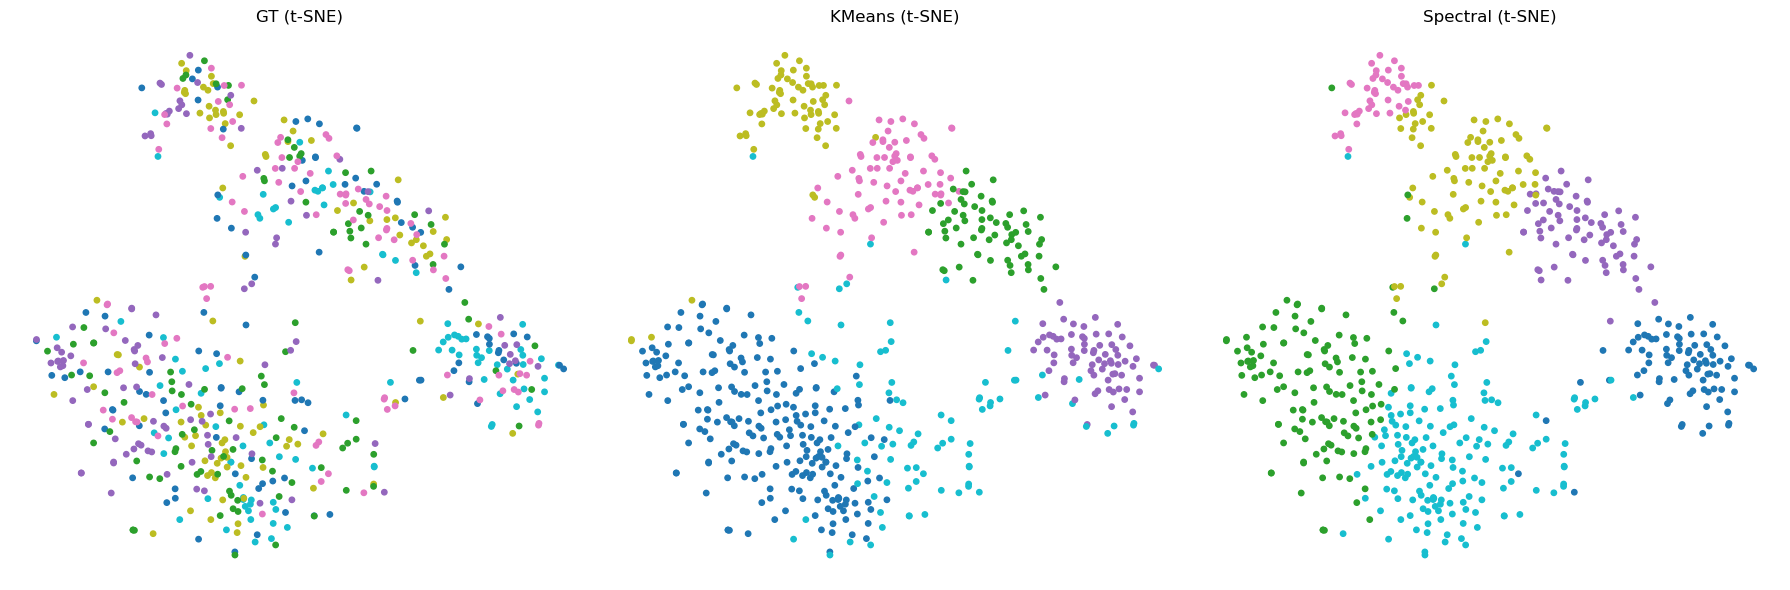

In [16]:
configurations = [
    {'name':'hybrid_100_33_100_4.1','func':'hybrid','harm_bins':100,'harm_range':33,'pol_bins':100,'pol_range':4.1},
    {'name':'polynomial_100_4.1','func':'polynomial','bins':100,'range':4.1},
    {'name':'harmonic_300_33','func':'harmonic','bins':300,'range':33},
]

print("Loading Data...")
graphs, labels, node_labels_list = download_and_load_enzymes()

for config in configurations:
    print(f"\n{'='*80}")
    print(f"Processing Configuration: {config['name']}")
    print(f"{'='*80}")
    
    X = generate_embeddings(graphs, node_labels_list, config)
    
    X_scaled, y_kmeans, y_spectral = perform_clustering_analysis(X, labels)
    
    km_ari = adjusted_rand_score(labels, y_kmeans)
    km_sil = silhouette_score(X_scaled, y_kmeans)
    
    sp_ari = adjusted_rand_score(labels, y_spectral)
    sp_sil = silhouette_score(X_scaled, y_spectral)
    print(f"--- Metrics for {config['name']} ---")
    print(f"K-Means  -> ARI: {km_ari:.4f} | Silhouette: {km_sil:.4f}")
    print(f"Spectral -> ARI: {sp_ari:.4f} | Silhouette: {sp_sil:.4f}")
    # 5. Visualize
    print("Generating Visualization...")
    visualize_clusters(X_scaled, labels, y_kmeans, y_spectral, config['name'])
    print(f"Plots displayed above and saved to 'clustering_visualization_{config['name']}.png'")